# Analysis of results

In [1]:
# -- Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

In [42]:
# -- Configuration

KIND = "linear"
METHOD = "emcee"
SMOOTHING = False
P_FREE = False
DIR = "../results_140822_tau_uniform/out/"
SAVE_FIG = True
DIR_SAVE = "../results_140822_tau_uniform/img/"
SCORE_REG = "RMSE"  # RMSE or rRMSE

KIND_STR = "reg" if KIND == "linear" else "clf"
SCORE_STR = SCORE_REG if KIND == "linear" else "Acc"
SCORE_STR_FULL = SCORE_REG if KIND == "linear" else "accuracy"

## Data gathering

In [43]:
# -- Data reading functions

def get_filenames(*dirs, extension="csv"):
    rkhs = []
    l2 = []
    non_gp = []
    real = []

    dirs_lst = [d for d in dirs if d is not None]

    for dirname in dirs_lst:
        for file in os.listdir(dirname):
            filename = file.split(".")[0]
            ext = file.split(".")[1]

            if SMOOTHING and "smoothing" not in filename:
                continue
            if not SMOOTHING and "smoothing" in filename:
                continue
                
            if P_FREE and "p_free" not in filename:
                continue
            if not P_FREE and "p_free" in filename:
                continue

            if METHOD in filename and KIND_STR in filename and ext == extension:
                if KIND == "linear" and "gbm" in filename:
                    non_gp += [dirname + filename]
                elif KIND == "logistic" and "mixture" in filename:
                    non_gp += [dirname + filename]
                elif "rkhs" in filename:
                    rkhs += [dirname + filename]
                elif "l2" in filename:
                    l2 += [dirname + filename]
                else:
                    real += [dirname + filename]

    # Sort
    for dataset in [rkhs, l2, non_gp, real]:
        dataset.sort(key=lambda x: x.split("/")[-1])

    return rkhs, l2, non_gp, real

In [44]:
# -- Data reading

rkhs, l2, non_gp, real = get_filenames(DIR)

## Score graphs

In [28]:
# -- Plotting functions

def plot_df(df, ax=None, legend=False, limit=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.margins(x=0.05)

    estimator = df["Estimator"].to_numpy(dtype=str)
    
    # Quick fix for name
    for i, name in enumerate(estimator):
        if "logistic" in name:
            estimator[i] = estimator[i].replace("+logistic", "+log")

    score = df["Mean " + SCORE_STR].to_numpy()
    sd = df["SD " + SCORE_STR].to_numpy()
    ours_idx = []

    # Outliers
    if KIND == "linear":
        if limit is None:
            q3, q1 = np.percentile(score + sd, [75 ,25])
            limit = q3 + 1.5*(q3 - q1)  # IQR
            
        outliers_idx = np.where(score > limit)[0]
        outliers = estimator[outliers_idx]
        symbol = ">"
    else:
        if limit is None:
            q3, q1 = np.percentile(score - sd, [75 ,25])
            limit = q1 - 1.5*(q3 - q1)  # IQR
        outliers_idx = np.where(score < limit)[0]
        outliers = estimator[outliers_idx]
        symbol = "<"

    # Plot our models
    all_outliers_ours = True
    for idx, idx_where in enumerate(np.char.find(estimator, METHOD)):
        if idx_where < 0:
            continue
        ours_idx.append(idx)

        if estimator[idx] in outliers:
            handles_ours_outliers = ax.plot(
                limit, estimator[idx], symbol, 
                color="darkorange", label="Our methods")
        else:
            all_outliers_ours = False
            handles_ours = ax.errorbar(
                score[idx],
                estimator[idx],
                xerr=sd[idx],
                color="darkorange",
                ecolor="darkorange",
                lw=1,
                fmt='o',
                markersize=5,
                label="Our methods"
            )

    estimator_rest = np.delete(estimator, ours_idx)
    score_rest = np.delete(score, ours_idx)
    sd_rest = np.delete(sd, ours_idx)

    all_outliers_rest = True
    for e, s, sdd in zip(estimator_rest, score_rest, sd_rest):
        if e in outliers:
            handles_rest_outliers = ax.plot(
                limit, e, symbol, color="navy", 
                label="Reference methods")
        else:
            all_outliers_rest = False
            handles_rest = ax.errorbar(
                s,
                e,
                xerr=sdd,
                color="navy",
                ecolor='navy',
                lw=1,
                fmt="o",
                markersize=5,
                label="Reference methods"
            )
            
    if all_outliers_ours:
        handles_ours = handles_ours_outliers
    if all_outliers_rest:
        handles_rest = handles_rest_outliers
    
    handles = [handles_ours, handles_rest]

    score_rest_no_outliers = np.delete(
        score, np.concatenate((outliers_idx, ours_idx)))
    if len(score_rest_no_outliers) > 0:
        handles_mean = ax.axvline(
            x=score_rest_no_outliers.mean(), color="teal", ls="--",
            lw=1.3, label=f"Mean of ref. methods")
        handles += [handles_mean]

    if legend:
        ax.legend(
            handles=handles,
            bbox_to_anchor=(1, 1))

    return handles


def plot_data_all(
    data,
    data_type_name,
    limit=None,
    legend=True,
    save=False,
    figsize=[None, None],
    bbox_legend=[None, None]
):
    n_data = len(data)
    if limit is None:
        limit = [(None, None)]*n_data

    if figsize[0] is None:
        figsize[0] = 3*n_data
    if figsize[1] is None:
        figsize[1] = 7
    if bbox_legend[0] is None:
        if n_data == 2:
            bbox_legend[0] = 1.15
        elif n_data == 3:
            bbox_legend[0] = 1.80
        elif n_data == 4:
            bbox_legend[0] = 2.45
        else:
            bbox_legend[0] = 1.0
    if bbox_legend[1] is None:
        bbox_legend[1] = -0.45

    fig = plt.figure(figsize=figsize)
    subfigs = fig.subfigures(nrows=1, ncols=n_data)
    if n_data == 1:
        subfigs = [subfigs]

    for j, (dataname, l) in enumerate(zip(data, limit)):
        basename = os.path.basename(dataname)
        df = pd.read_csv(dataname + ".csv")

        basename_split = basename.split("_")
        if "mixture" in dataname:
            model = "mixture"
        elif "gbm_" in dataname:
            model = "gbm"
        elif "gp_" in dataname:
            model = basename_split[5]
        else:
            model = basename_split[3]

        real_data = False
        if "homoscedastic" in dataname:
            dataname_short = "BM(0, 1) vs. BM(t, 1)"
        elif "heteroscedastic" in dataname:
            dataname_short = "BM(0, 1) vs. BM(0, 2)"
        elif "fractional" in dataname:
            dataname_short = "Fractional Brownian (H=0.8)"
        elif "brownian" in dataname:
            dataname_short = "Standard Brownian"
        elif "exponential" in dataname:
            dataname_short = "Gaussian"
        elif "ornstein_uhlenbeck" in dataname:
            dataname_short = "Ornstein-Uhlenbeck"
        elif "gbm_rkhs" in dataname:
            dataname_short = "Standard GBM + RKHS"
        elif "gbm_l2" in dataname:
            dataname_short = "Standard GBM + L2"
        else:
            dataname_short = model.capitalize()
            real_data = True
        
        if "smoothing" in basename:
            dataname_short += " - smooth"
        if "p_free" in basename:
            dataname_short += " (p free)"

        # Get different strategies and order by score
        df_bayesian = df[~df["Estimator"].str.contains("\+")]
        df_bayesian = df_bayesian.sort_values("Estimator")

        df_var_sel = df[df["Estimator"].str.contains("\+")]
        df_var_sel = df_var_sel.sort_values("Estimator")

        ##
        # PLOT
        ##

        subfig = subfigs[j]
        subfig.suptitle(dataname_short, fontweight='semibold', y=0.96)
        ax1, ax2 = subfig.subplots(nrows=2, ncols=1)

        if j != 0 and j != n_data - 1:
            ax1.set_yticks([])
            ax2.set_yticks([])
        if j != 0 and j == n_data - 1:
            ax1.yaxis.tick_right()
            ax2.yaxis.tick_right()

        kind_title = 'Regression' if KIND == "linear" else 'Classification'
        ax1.set_title(f"{kind_title} methods", fontsize=10)
        ax2.set_title("Variable selection methods", fontsize=10)
        ax1.set_xlabel(SCORE_STR)
        ax2.set_xlabel(SCORE_STR)

        _ = plot_df(df_bayesian, ax1, legend=False, limit=l[0])
        handles = plot_df(df_var_sel, ax2, limit=l[1])

        if legend and j == 0:
            ax2.legend(
                loc="lower center",
                handles=handles,
                ncol=3,
                fancybox=True,
                shadow=True,
                fontsize=11,
                bbox_to_anchor=bbox_legend,
            )

        subfig.subplots_adjust(hspace=0.4)
        
    #orientation = "left" if KIND == "linear" else "right"
    #data_type = "data sets" if real_data else "kernels"
    #fig.suptitle(
    #    f"Mean {SCORE_STR_FULL} for different {data_type} "
    #    f"({orientation} is better)",
    #    y=1.02
    #)

    if save:
        filename_save = (
            ("reg_" if KIND == "linear" else "clf_")
            + METHOD + "_"
            + data_type_name
            + ("_p_free" if "p_free" in basename else "")
            + ("_smooth" if "smoothing" in basename else "")
            + ".png"
        )
        plt.savefig(DIR_SAVE + filename_save, bbox_inches='tight')

In [51]:
# -- Plot configuration

dataname = "real"
limit = [(None, None), (None, None), (None, None), (None, None)]
bbox_legend = [None, None]
figsize = [None, None]

if dataname == "rkhs":
    data_all = rkhs
elif dataname == "l2":
    data_all = l2
elif dataname == "nongp":
    data_all = non_gp
else:
    data_all = real

--> Linear emcee REAL <--


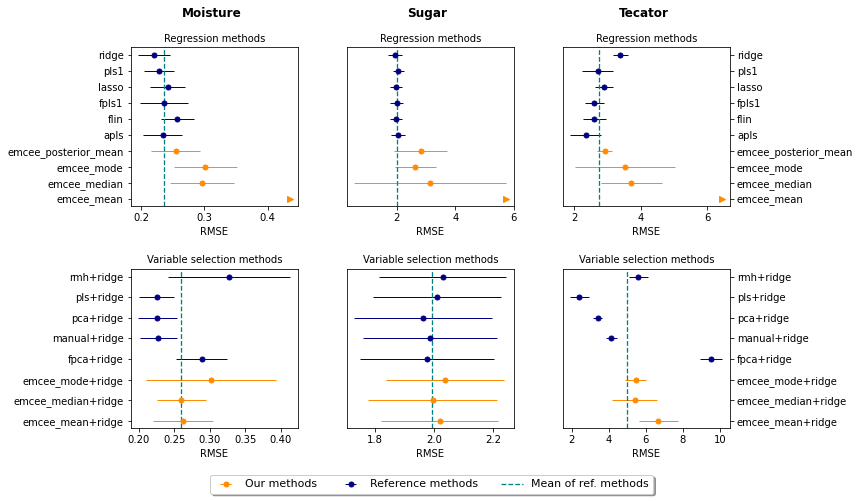

In [52]:
# -- Plot

print(
    "--> "
    + KIND.capitalize()
    + " " + METHOD
    + " " + dataname.upper()
    + (" (smooth)" if SMOOTHING else "")
    + " <--")

plot_data_all(
    data_all,
    dataname,
    limit=limit,
    legend=True,
    figsize=figsize,
    bbox_legend=bbox_legend,
    save=SAVE_FIG)

### Vertical plots

In [21]:
# -- Plotting functions

def plot_comparison(filename, data, top, kind):
    kernel_abbr = {
        "fractional": "fBM",
        "ornstein": "O-U",
        "squared": "RBF"
    }

    # Get info
    name = filename.split('_')
    if "kernel" in name:
        model = kernel_abbr[name[2]]
        kernel = True
    else:
        model = name[2]
        kernel = False

    if "BSpline" in filename:
        smoothing = "Base BSpline(16)"
    elif "Watson" in filename:
        smoothing = "Suavizado N-W"
    else:
        smoothing = "Sin suavizado"

    title = f"{model}" + (" kernel" if kernel else "") + f" - {smoothing}"

    # Get data
    emcee_data = data["emcee_best"][0]
    varsel_data = data["var_sel_best"][:top]
    sklearn_data = data["sk_best"][:top]

    n_sk = len(sklearn_data)
    n_emcee = 1
    n_varsel = len(varsel_data)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, 6), sharey=True)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    colors_sk = cm.Dark2.colors[:n_sk]
    colors_varsel = cm.Set1.colors[:n_varsel]

    ax1.scatter(
        np.zeros(n_sk), sklearn_data, marker="2",
        color=colors_sk, alpha=0.8, s=60, label="Comp.")
    ax1.set_xticks([])
    ax1.set_title("Comp.")
    if kind == "reg":
        ax1.set_ylabel("MSE")
    else:
        ax1.set_ylabel("Accuracy")

    ax2.set_title("Emcee")
    ax2.set_xticks([])
    ax2.scatter(
        np.zeros(n_varsel), varsel_data, marker="+",
        alpha=0.8, color=colors_varsel, s=50, label="Var. sel.")
    ax2.scatter(
        np.zeros(n_emcee), emcee_data, marker="*",
        alpha=1.0, s=80, color="r", label="MCMC")

    plt.suptitle(title)
    #plt.legend(bbox_to_anchor=(2.75, 1))
    plt.show()


def plot_all(rkhs, l2, real, top=5, kind="clf"):
    print(f" -----> RKHS ({kind}) <-----")
    for file in rkhs:
        data = np.load(f'out/{file}')
        filename = file[:-4]

        plot_comparison(filename, data, top, kind)

    print(f" -----> L2 ({kind}) <-----")
    for file in l2:
        data = np.load(f'out/{file}')
        filename = file[:-4]

        plot_comparison(filename, data, top, kind)

    print(f" -----> REAL ({kind}) <-----")
    for file in real:
        data = np.load(f'out/{file}')
        filename = file[:-4]

        plot_comparison(filename, data, top, kind)

 -----> RKHS (clf) <-----


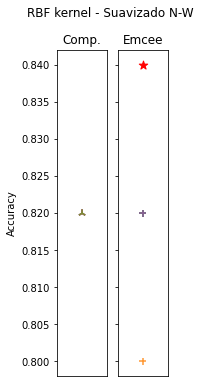

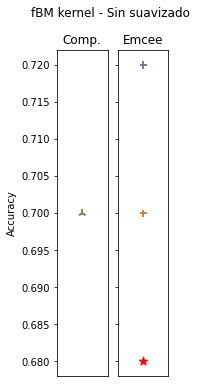

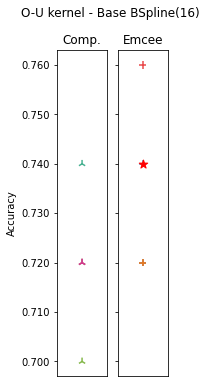

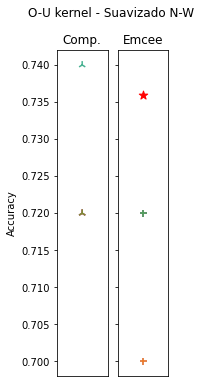

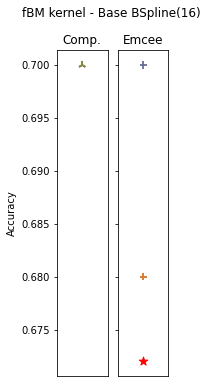

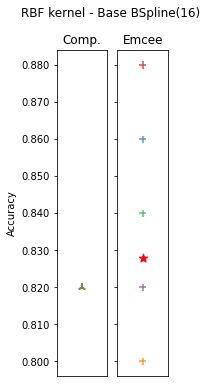

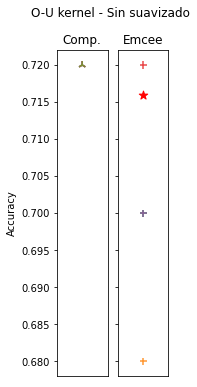

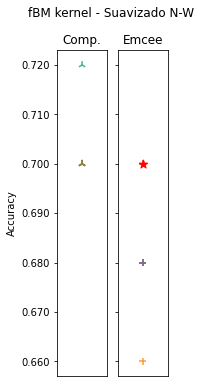

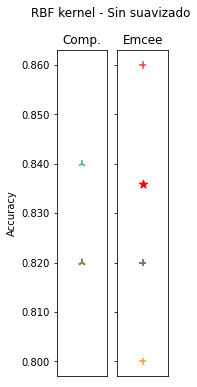

 -----> L2 (clf) <-----


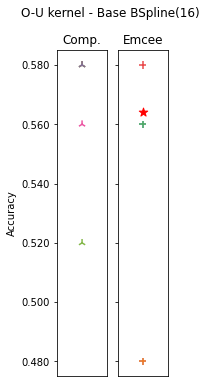

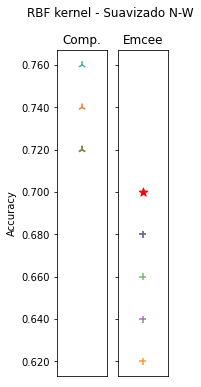

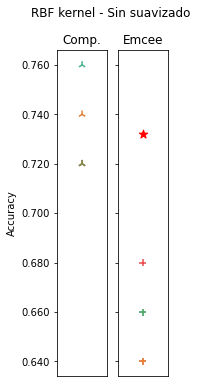

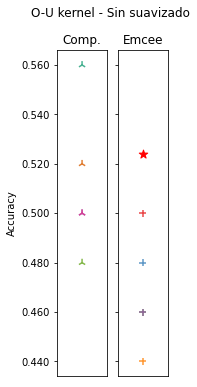

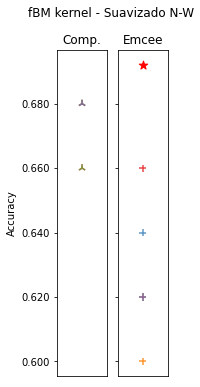

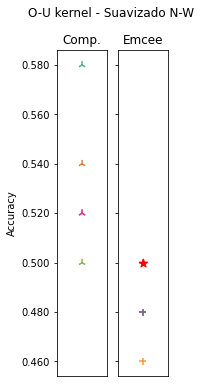

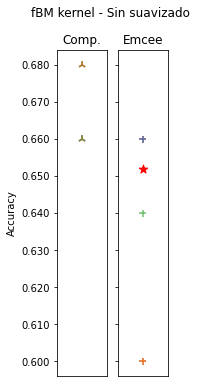

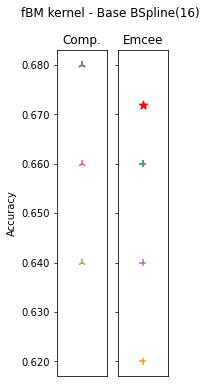

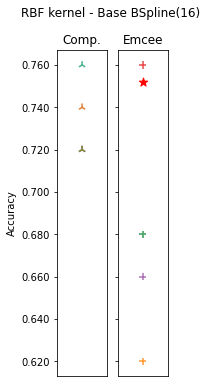

 -----> REAL (clf) <-----


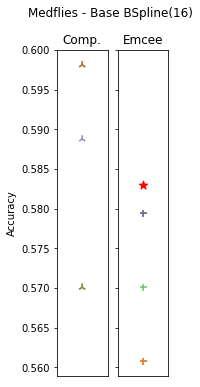

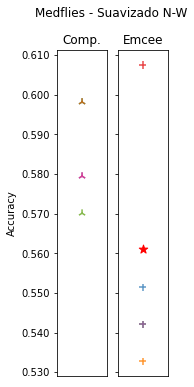

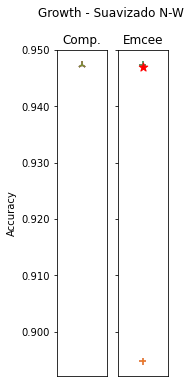

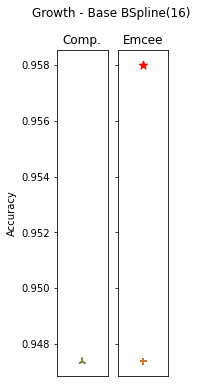

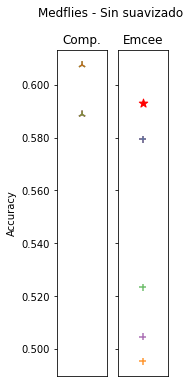

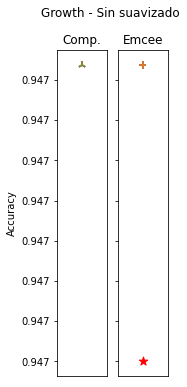

In [6]:
plot_all(rkhs_clf, l2_clf, real_clf, kind="clf")

## CV data

In [146]:
rkhs, l2, non_gp, real = get_filenames(DIR, extension="npz")

In [147]:
arr = np.load(rkhs[0] + ".npz", allow_pickle=True)

In [148]:
for a in arr.keys():
    print(a)

score_bayesian_all
score_var_sel_all


In [ ]:
# Sklearn scores
arr["score_ref_all"]

In [149]:
# Each row is a different rep, inside the arrays are # n_splits x params_shape
# e.g. for 5 folds, p in [2, 3] and eta in [0.01, 0.1], shape is (5, 2, 2).
arr["score_bayesian_all"]

# There are also the parameter vectors (eta, p) and, in the case of INCLUDE_P,
# the effective n_components used in each case.

array([{'posterior_mean': array([[[ -2.4112,  -2.3342,  -2.4824,  -2.3607,  -2.508 ,  -2.3759,
                 -2.3793],
               [ -2.4029,  -2.4194,  -2.3797,  -2.2903,  -2.3509,  -2.3407,
                 -2.6081],
               [ -2.7521,  -2.5159,  -2.811 ,  -2.8187,  -2.684 ,  -3.071 ,
                 -3.7555],
               [ -2.702 ,  -2.7902,  -2.7024,  -2.8962,  -2.7057,  -3.3971,
                 -9.0326],
               [ -1.3893,  -1.6157,  -2.4929,  -1.5567,  -2.1537,  -2.7133,
                 -4.5911],
               [ -0.8132,  -1.002 ,  -0.8085,  -0.8487,  -0.7207,  -0.7323,
                 -2.1196],
               [ -1.9102,  -1.2164,  -3.0435,  -1.1003,  -1.3708,  -1.99  ,
                -11.5066],
               [ -1.3194,  -1.3466,  -1.3359,  -5.7663,  -1.6815,  -1.635 ,
                 -6.3032],
               [ -3.0496,  -2.8441,  -2.1216,  -2.7525,  -3.0686,  -3.92  ,
                -17.3968],
               [ -2.9789,  -3.7881,  -2.7054,  -4.5404

In [156]:
first = arr["score_bayesian_all"][2]
first_pm = first['mode']
first_pm.shape # (n_splits x p x eta)

(5, 10, 7)

In [157]:
v=first_pm.mean(axis=0)  # (p x eta)

In [158]:
v

array([[ -2.5449,  -2.5457,  -2.5407,  -2.5512,  -2.5518,  -2.5542,
         -2.5485],
       [-46.6589, -34.9338, -38.9621, -11.6087, -16.6187,  -2.7901,
         -2.9583],
       [ -3.1682,  -1.9588, -41.3759, -44.0828, -38.3175,  -2.2202,
         -2.755 ],
       [-18.4702, -14.7291, -43.9625,  -1.4767,  -9.1226,  -1.9552,
        -35.0749],
       [-29.3433, -14.1077, -36.0008, -18.0598,  -1.9246,  -4.7949,
         -4.5177],
       [-13.9083, -38.6051, -17.3907, -52.8822, -37.618 , -22.3205,
        -10.4928],
       [-19.027 , -10.5374, -30.1411, -37.2612,  -3.9775, -38.4163,
        -21.2197],
       [-26.035 , -39.9634, -20.9604, -28.6854, -73.0703, -38.0414,
        -53.8571],
       [-15.0056, -19.0698, -26.2713, -63.4818, -53.9227,  -4.2989,
        -35.6685],
       [-16.2722,  -1.9108, -11.7888, -13.7179, -30.5361, -14.9902,
        -10.7729]])

In [33]:
np.unravel_index(v.argmax(), v.shape)

(5, 0)